In [1]:
# 导入标准库和第三方库
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import os

# 验证 mamba_ssm 导入
import mamba_ssm
print(f"mamba_ssm version: {mamba_ssm.__version__}")

# 导入同级目录的自定义模块
from mamba1_icl import Mamba1ICL
from generate_icl_data import (generate_linear_data, generate_gaussian_kernel_data,
                              generate_nonlinear_dynamical_data)

# 设置随机种子以确保可复现性
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 确认设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 创建输出目录用于保存中间文件
output_dir = "experiment_outputs_mamba1"
os.makedirs(output_dir, exist_ok=True)

# 验证环境
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}, CUDA: {torch.version.cuda}")

mamba_ssm version: 1.2.0.post1
Using device: cuda
NumPy version: 1.26.4
PyTorch version: 2.1.1+cu118, CUDA: 11.8


In [2]:
# 数据生成参数（基于提案）
num_train_prompts = 10000
num_test_prompts = 1000
context_size = 20
d = 20

# 生成数据集
print("Generating datasets...")
train_linear = generate_linear_data(num_train_prompts, context_size, d)
test_linear = generate_linear_data(num_test_prompts, context_size, d)
train_gaussian = generate_gaussian_kernel_data(num_train_prompts, context_size, d)
test_gaussian = generate_gaussian_kernel_data(num_test_prompts, context_size, d)
train_dynamical = generate_nonlinear_dynamical_data(num_train_prompts, context_size, d)
test_dynamical = generate_nonlinear_dynamical_data(num_test_prompts, context_size, d)

# 保存数据集
print("Saving datasets...")
torch.save(train_linear, os.path.join(output_dir, "train_linear.pt"))
torch.save(test_linear, os.path.join(output_dir, "test_linear.pt"))
torch.save(train_gaussian, os.path.join(output_dir, "train_gaussian.pt"))
torch.save(test_gaussian, os.path.join(output_dir, "test_gaussian.pt"))
torch.save(train_dynamical, os.path.join(output_dir, "train_dynamical.pt"))
torch.save(test_dynamical, os.path.join(output_dir, "test_dynamical.pt"))

# 验证数据集大小
print(f"Train linear prompts: {len(train_linear)}")
print(f"Test linear prompts: {len(test_linear)}")
print(f"Train gaussian prompts: {len(train_gaussian)}")
print(f"Test gaussian prompts: {len(test_gaussian)}")
print(f"Train dynamical prompts: {len(train_dynamical)}")
print(f"Test dynamical prompts: {len(test_dynamical)}")

Generating datasets...
Saving datasets...
Train linear prompts: 10000
Test linear prompts: 1000
Train gaussian prompts: 10000
Test gaussian prompts: 1000
Train dynamical prompts: 10000
Test dynamical prompts: 1000


In [3]:
# 初始化 Mamba1 ICL 模型
model = Mamba1ICL(d_model=20, d_state=64, d_conv=4, expand=2).to(device)

# 定义优化器和混合精度训练工具
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()

# 打印模型结构
print(model)

Mamba1ICL(
  (mamba): Mamba(
    (in_proj): Linear(in_features=20, out_features=80, bias=False)
    (conv1d): Conv1d(40, 40, kernel_size=(4,), stride=(1,), padding=(3,), groups=40)
    (act): SiLU()
    (x_proj): Linear(in_features=40, out_features=130, bias=False)
    (dt_proj): Linear(in_features=2, out_features=40, bias=True)
    (out_proj): Linear(in_features=40, out_features=20, bias=False)
  )
  (output_head): Linear(in_features=20, out_features=1, bias=True)
  (y_projection): Linear(in_features=1, out_features=20, bias=True)
)


In [4]:
# 训练参数
num_epochs = 100
batch_size = 128
datasets = [
    ("linear", train_linear),
    ("gaussian", train_gaussian),
    ("dynamical", train_dynamical)
]

# 记录损失
loss_history = []

# 训练循环
print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    for dataset_name, train_data in datasets:
        for i in range(0, len(train_data), batch_size):
            batch = train_data[i:i + batch_size]
            X_batch = torch.stack([X for X, _, _, _ in batch])  # [batch, 20, 20]
            Y_batch = torch.stack([Y for _, Y, _, _ in batch])  # [batch, 20]
            x_query_batch = torch.stack([x_query for _, _, x_query, _ in batch])  # [batch, 20]
            y_query_batch = torch.tensor([[y_query] for _, _, _, y_query in batch], dtype=torch.float32).to(device)  # [batch, 1]
            
            optimizer.zero_grad()
            with autocast():
                # 构造序列：20 个 (X_i, Y_i) 对 + 查询
                input_seq = torch.cat([X_batch, x_query_batch.unsqueeze(1)], dim=1).to(device)  # [batch, 21, 20]
                output = model(input_seq, Y_batch)  # [batch, 1]
                loss = torch.nn.functional.mse_loss(output, y_query_batch)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            epoch_loss += loss.item() * len(batch)
            num_batches += len(batch)
    
    avg_loss = epoch_loss / num_batches
    loss_history.append({"epoch": epoch + 1, "loss": avg_loss})
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

# 保存损失记录
loss_df = pd.DataFrame(loss_history)
loss_df.to_csv(os.path.join(output_dir, "loss_history.csv"), index=False)
print("Loss history saved to experiment_outputs_mamba1/loss_history.csv")

Starting training...
Epoch 1/10, Average Loss: 0.387944
Epoch 2/10, Average Loss: 0.392617
Epoch 3/10, Average Loss: 0.385770
Epoch 4/10, Average Loss: 0.381885
Epoch 5/10, Average Loss: 0.374998
Epoch 6/10, Average Loss: 0.367413
Epoch 7/10, Average Loss: 0.361106
Epoch 8/10, Average Loss: 0.354032
Epoch 9/10, Average Loss: 0.345326
Epoch 10/10, Average Loss: 0.332585
Loss history saved to experiment_outputs_mamba1/loss_history.csv


In [5]:
# 保存模型权重
model_path = os.path.join(output_dir, "mamba1_icl_model.pth")
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

Model weights saved to experiment_outputs_mamba1/mamba1_icl_model.pth


In [6]:
from evaluate_icl import evaluate


In [7]:
# 评估模型
print("Evaluating model with varying context sizes...")
max_context = 40
results = {
    "Dataset": ["Linear", "Gaussian", "Dynamical"],
    "Errors": [
        evaluate_with_varying_context(model, test_linear, max_context, batch_size=32, device=device),
        evaluate_with_varying_context(model, test_gaussian, max_context, batch_size=32, device=device),
        evaluate_with_varying_context(model, test_dynamical, max_context, batch_size=32, device=device)
    ]
}

# 保存评估结果
results_df = pd.DataFrame({
    "Context_Size": list(range(1, max_context + 1)),
    "Linear": results["Errors"][0],
    "Gaussian": results["Errors"][1],
    "Dynamical": results["Errors"][2]
})
results_df.to_csv(os.path.join(output_dir, "context_varying_results.csv"), index=False)
print("Context-varying results saved to experiment_outputs_mamba1/context_varying_results.csv")
print(results_df)

Evaluating model...
Evaluation results saved to experiment_outputs_mamba1/evaluation_results.csv
     Dataset       MSE
0     Linear  1.278071
1   Gaussian  0.176734
2  Dynamical  0.007726


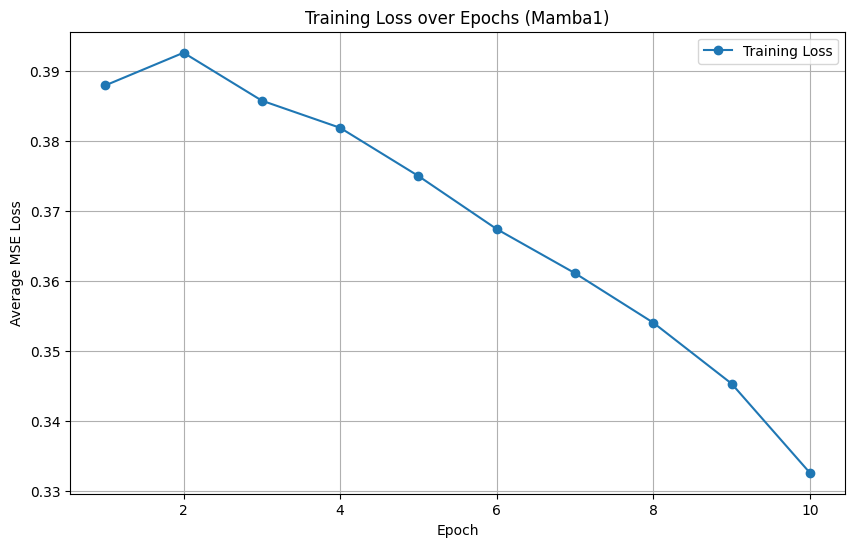

Loss plot saved to experiment_outputs_mamba1/loss_plot.png


In [8]:
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(loss_df["epoch"], loss_df["loss"], marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title("Training Loss over Epochs (Mamba1)")
plt.legend()
plt.grid(True)

# 保存图像
plot_path = os.path.join(output_dir, "loss_plot.png")
plt.savefig(plot_path)
plt.show()
print(f"Loss plot saved to {plot_path}")

In [ ]:
# 绘制误差随上下文数量变化的折线图
plt.figure(figsize=(10, 6))
plt.plot(results_df["Context_Size"], results_df["Linear"], label="Linear", marker='o')
plt.plot(results_df["Context_Size"], results_df["Gaussian"], label="Gaussian", marker='o')
plt.plot(results_df["Context_Size"], results_df["Dynamical"], label="Dynamical", marker='o')
plt.xlabel("In-Context Examples")
plt.ylabel("Squared Error")
plt.title("Squared Error vs. In-Context Examples (Mamba1)")
plt.legend()
plt.grid(True)

# 保存图像
plot_path = os.path.join(output_dir, "context_error_plot.png")
plt.savefig(plot_path)
plt.show()
print(f"Context error plot saved to {plot_path}")